# Document Classification with Hierarchical Clustering

### Step - 1: Prepare data to feed HAC

In [1]:
from sklearn.datasets import fetch_20newsgroups
from pprint import pprint
import matplotlib.pyplot as plt
import numpy as np

# set random seed
np.random.seed(seed = 4200)

# Fetch dataset without removing headers and footers 
newsgroups_train = fetch_20newsgroups(subset = "train")

# list of topics available in the dataset
pprint(list(newsgroups_train.target_names))

['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']


In [2]:
# sample message from unaltered data
print(newsgroups_train.data[5700])

From: egreen@East.Sun.COM (Ed Green - Pixel Cruncher)
Subject: Re: Round Two
Organization: Sun Microsystems, RTP, NC
Lines: 22
Distribution: world
Reply-To: egreen@East.Sun.COM
NNTP-Posting-Host: laser.east.sun.com

In article 29788@serval.net.wsu.edu, bill@wsuaix.csc.wsu.edu (William E. Johns;S23015) writes:
>
>If Good Sam got 300 bricks, delivered
>first class postage to their door, at their expense, I bet they would change
>their policies about mailing lists or about who can use their facilities
>quickly. 

And if the Lord God Almighty parted the sky and make a personal
appearance at their Board of Directors meeting, they would also change
their policies.  The odds are about equal.

>I am curious as to how many bricks I will have to send before this situatiion
>is cleared up to my satisfaction.  I suspect about 5.  We shall see.

You'll be extremely lucky if you ever get one through.

---
Ed Green, former Ninjaite |I was drinking last night with a biker,
  Ed.Green@East.Sun.COM   |a

In [3]:
# Fetch dataset after removing headers and footers and specifying categories
newsgroups = fetch_20newsgroups(subset = "test", categories = ['comp.graphics',
 'comp.os.ms-windows.misc','comp.sys.ibm.pc.hardware','comp.sys.mac.hardware','comp.windows.x', 'talk.politics.guns',
 'talk.politics.mideast', 'rec.sport.baseball','rec.sport.hockey',],  remove = ("headers", "footers"))

# make the dataset of managable size
class DataSubset:
    def __init__(self, data_set, subset):
        attrs = newsgroups.__dir__()
        for attr in attrs:
            values = getattr(data_set, attr)
            #print('length = {}'.format(len(values)))
            try:
                setattr(self, attr, [values[i] for i in subset])
            except:
                setattr(self, attr, values)
        
# uniformly pick indices for making a subset
subset = np.random.choice(len(newsgroups.data)-1, 100, replace=False)

# finally create our managable dataset
newsgrps = DataSubset(newsgroups, subset)

# sample message after removing the headers and footers
#print(len(newsgrps.target_names))


### Step - 2: Vectorize text and create dendrogram

In [454]:
# vectorize text using TF-IDF
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer()
vectors = vectorizer.fit_transform(newsgrps.data)

# look at the number of total words in the collection of texts (= 114751)
print(vectors.shape)

(100, 4192)


In [455]:
from scipy.cluster.hierarchy import dendrogram, linkage, single, ward, average
from sklearn.metrics.pairwise import pairwise_distances
from scipy.spatial.distance import pdist
import numpy as np
#print(vectors.todense())

pd = pdist(vectors.todense())
Z = ward(pd)
#print(pd.shape)
#vectors.dot(vectors.T)
#print(pd)

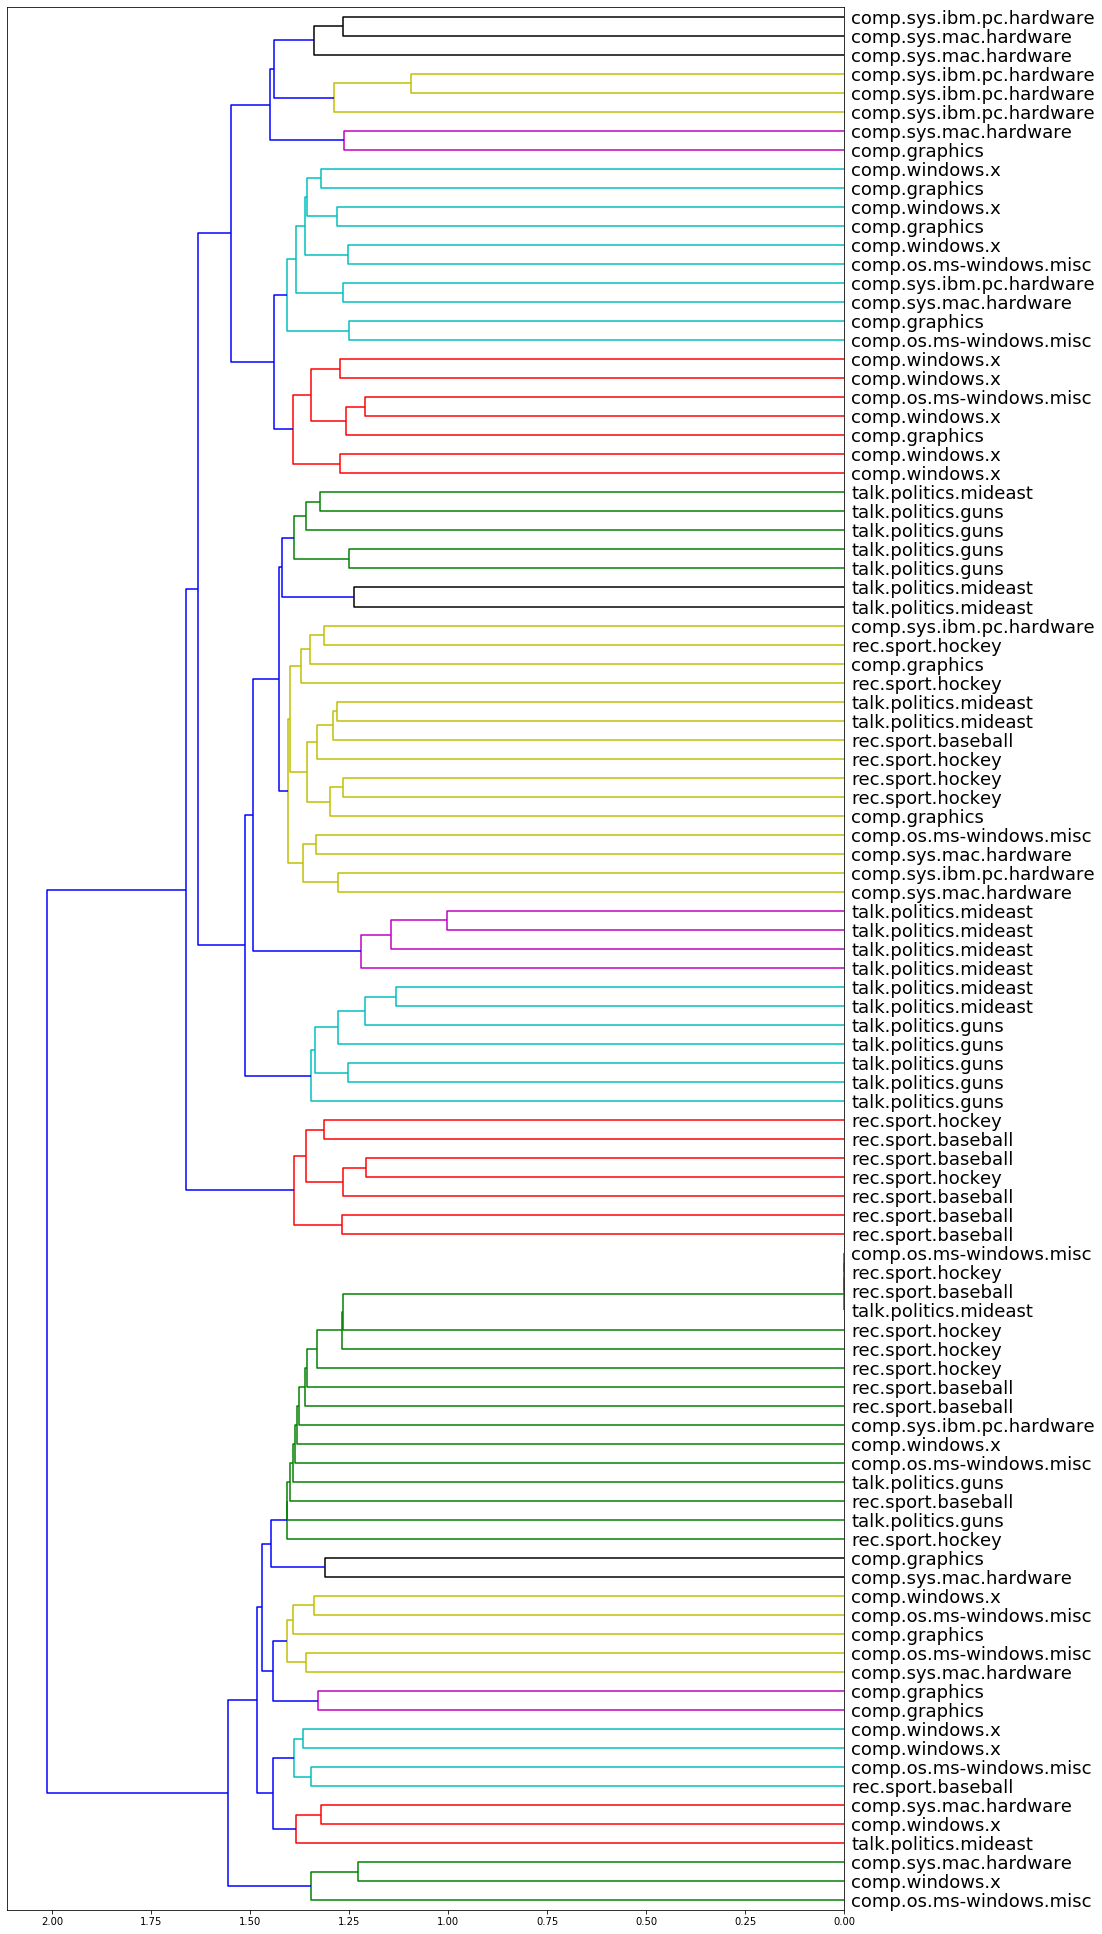

In [461]:
# figure out leaf labels 


fig = plt.figure(figsize =(15, 35))
ax = fig.add_subplot(1,1,1)

dendrogram(Z, ax=ax, show_contracted=True, leaf_font_size=18,\
           labels = [newsgrps.target_names[i] for i in newsgrps.target], orientation="left");

plt.show()

In [362]:
from scipy.cluster.hierarchy import fcluster
fl = fcluster(Z, 20, criterion = 'maxclust')

In [429]:
print(fl)

[ 4  1  2 29  4  4 25 24 31  8 28 15  9 20  4 11 21 33 26 22 16 13 38  8
 34 39  4  6  7 17 18 32 35 27  3  4 12  5  3 36 23  1 14 37 19  4 32 30
  4 10]


In [432]:
from collections import Counter
clusters = [0]*20
cluster_labels = ['']*20 
for i in range(20):
    clusters[i] =  [j for j, k in enumerate(fl) if k == i+1]
    cluster_labels[i] = Counter([newsgrps.target[pt] for pt in clusters[i]]).most_common(1)[0][0]
        
misclassifications = 0
for i in range(20):
    for pt in clusters[i]:
        if cluster_labels[i] != newsgrps.target[pt]:
            misclassifications += 1
            
print(misclassifications)

9


In [433]:
print([newsgrps.target_names[i] for i in cluster_labels])

['rec.autos', 'comp.sys.ibm.pc.hardware', 'comp.sys.ibm.pc.hardware', 'sci.space', 'sci.crypt', 'soc.religion.christian', 'rec.sport.baseball', 'talk.politics.mideast', 'talk.politics.mideast', 'sci.med', 'rec.motorcycles', 'talk.politics.misc', 'comp.sys.mac.hardware', 'comp.sys.ibm.pc.hardware', 'rec.motorcycles', 'sci.med', 'talk.politics.guns', 'comp.sys.mac.hardware', 'sci.electronics', 'rec.autos']


In [316]:
print(clusters[3])

[1, 5, 13, 35, 45, 68, 121, 134, 139, 159, 160, 166, 171, 182, 185, 186, 195, 207, 210, 226, 245, 260, 261, 268, 289, 296, 307, 321, 333, 356, 359, 360, 369, 388, 389, 396, 398, 405, 409, 430, 440, 450, 459, 465, 466, 476, 480, 484, 489, 492]


### Step - 3: Find the optimal number of clusters using silhouette score and explore the optimal clusters

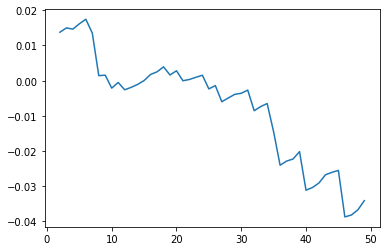

Optimal number of clusters = 6


In [465]:
from sklearn.metrics import silhouette_score
k, ss = list(range(2, 50)), []
for i in k:
    fl = fcluster(Z, i, criterion = 'maxclust')
    ss.append(silhouette_score(vectors.todense(),fl))
plt.plot(k, ss)
plt.show()
print("Optimal number of clusters = {}".format(np.array(ss).argmax()+2))